In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np
import joblib
from sklearn.utils import class_weight
import keras
import os

2023-11-14 23:41:04,259 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine quality dataset",
                                  labels=["quality"],
                                  query=query)
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.1)

Finished: Reading data from Hopsworks, using ArrowFlight (1.09s) 


In [4]:
n_input = 7 # Number of features
n_hidden = 256  # Number of hidden nodes
n_out = 3 # Number of classes
"""
wine_df = pd.read_csv("Dataset/winequalityN.csv")
wine_df['quality'] = wine_df.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 6 else 2)
wine_df['type'] = wine_df.type.apply(lambda q: 0 if q == 'white' else 1)
wine_df = wine_df.dropna()

n_samples = y_train.shape[0] + y_test.shape[0]
y_train = wine_df['quality'].to_numpy()[:round(n_samples * 0.9)]
X_train = wine_df.drop(columns=['quality']).to_numpy()[:round(n_samples * 0.9)]
y_test = wine_df['quality'].to_numpy()[round(n_samples * 0.9):]
X_test = wine_df.drop(columns=['quality']).to_numpy()[round(n_samples * 0.9):]
"""

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = keras.Sequential([
    keras.layers.Dense(n_hidden, input_dim=n_input, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.Dense(n_out, activation='softmax')
])
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train['quality']),
                                                 y=y_train['quality'])
print(class_weights)
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, class_weight=dict(zip(np.unique(y_train['quality']), class_weights)), batch_size=256)

2023-11-14 23:41:11,922 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

[0.90020869 0.75714058 1.75936225]
Epoch 1/150
2023-11-14 23:41:12,161 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

2023-11-14 23:41:12,410 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

19/19 [==============================] - 1s 12ms/step - loss: 1.2268 - accuracy: 0.4552 - val_loss: 2.0281 - val_accuracy: 0.2708
Epoch 2/150
19/19 [==============================] - 0s 5ms/step - loss:

In [5]:
X_train

,type,volatile_acidity,residual_sugar,chlorides,total_sulfur_dioxide,density,alcohol
0,1,0.59,2.5,0.093,58.0,1.00020,9.3
1,0,0.18,1.5,0.043,155.0,0.99238,10.2
2,1,0.21,1.6,0.067,10.0,0.99552,11.1
4,0,0.18,1.4,0.047,106.0,0.99383,10.5
5,0,0.27,15.2,0.046,41.0,0.99665,10.9
...,...,...,...,...,...,...,...
5268,0,0.29,9.9,0.058,115.0,0.99567,10.9
5269,0,0.19,5.1,0.034,204.0,0.99420,10.1
5270,0,0.26,8.2,0.046,183.0,0.99584,9.4
5271,0,0.28,7.7,0.045,195.0,0.99540,11.0


In [6]:
y_train

,quality
0,1
1,0
2,2
4,2
5,1
...,...
5268,0
5269,0
5270,0
5271,1


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

17/17 [==============================] - 0s 907us/step


In [8]:
print(metrics)

{'0': {'precision': 0.7115384615384616, 'recall': 0.5235849056603774, 'f1-score': 0.6032608695652174, 'support': 212.0}, '1': {'precision': 0.4486486486486487, 'recall': 0.3878504672897196, 'f1-score': 0.41604010025062654, 'support': 214.0}, '2': {'precision': 0.39572192513368987, 'recall': 0.7254901960784313, 'f1-score': 0.5121107266435987, 'support': 102.0}, 'accuracy': 0.5075757575757576, 'macro avg': {'precision': 0.5186363451069333, 'recall': 0.5456418563428428, 'f1-score': 0.5104705654864808, 'support': 528.0}, 'weighted avg': {'precision': 0.5439784110238656, 'recall': 0.5075757575757576, 'f1-score': 0.5097711740892183, 'support': 528.0}}


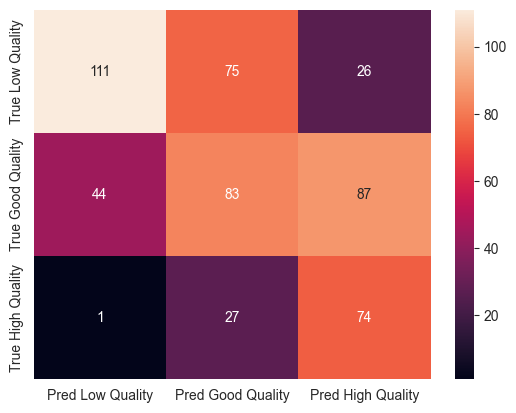

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Low Quality', 'True Good Quality', 'True High Quality'],
                     ['Pred Low Quality', 'Pred Good Quality', 'Pred High Quality'])
cm = sns.heatmap(df_cm, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
model.save_weights(model_dir + '/wine_model.h5')
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/191638/models/wine_model/1


Model(name: 'wine_model', version: 1)